In [6]:
# !pip install numpy
# !pip install matplotlib
# !pip install Pillow
# !pip install tqdm
# !pip install tensorflow
# !pip install faiss-cpu
# !pip install opencv-python
# !pip install opencv-contrib-python

# # ImageHash
# !pip install ImageHash

# # Các thư viện phụ thuộc khác
# !pip install scipy
# !pip install pandas


In [7]:
# Import thư viện
from tensorflow import keras
from keras.applications import EfficientNetB0
from keras.preprocessing import image
from keras.applications.efficientnet import preprocess_input
import numpy as np
import faiss
import cv2
import imagehash
from PIL import Image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [8]:
# Khởi tạo model
model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

def extract_features(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model.predict(x)
    return features[0]

def calculate_hash(img_path):
    return imagehash.average_hash(Image.open(img_path))

In [9]:
# Trích xuất và lưu đặc trưng
def update_features_cache():
    input_dir = "originalImages"
    cache_file = "image_features.pkl"
    
    # Lấy danh sách ảnh hiện tại
    current_images = [os.path.join(input_dir, f) for f in os.listdir(input_dir) 
                     if f.endswith(('.jpg', '.png', '.jpeg'))]
    
    features = []
    hashes = []
    image_paths = []
    new_images = set(current_images)
    
    # Kiểm tra cache
    if os.path.exists(cache_file):
        print("Đang tải cache...")
        with open(cache_file, 'rb') as f:
            cached_data = pickle.load(f)
            cached_paths = set(cached_data['image_paths'])
            current_paths = set(current_images)
            
            # Tìm ảnh mới và ảnh đã xóa
            new_images = current_paths - cached_paths
            removed_images = cached_paths - current_paths
            
            if not new_images and not removed_images:
                print("Không có thay đổi trong thư mục ảnh")
                return cached_data['features'], cached_data['hashes'], cached_data['image_paths']
            
            print(f"Phát hiện {len(new_images)} ảnh mới, {len(removed_images)} ảnh đã xóa")
            
            # Giữ lại các ảnh còn tồn tại
            for idx, path in enumerate(cached_data['image_paths']):
                if path in current_paths:
                    features.append(cached_data['features'][idx])
                    hashes.append(cached_data['hashes'][idx])
                    image_paths.append(path)
    
    # Xử lý ảnh mới
    if new_images:
        print("Đang xử lý ảnh mới...")
        for img_path in tqdm(new_images):
            try:
                feat = extract_features(img_path)
                img_hash = calculate_hash(img_path)
                features.append(feat)
                hashes.append(img_hash)
                image_paths.append(img_path)
            except Exception as e:
                print(f"Lỗi khi xử lý {img_path}: {str(e)}")
    
    features = np.array(features)
    
    # Lưu cache mới
    print("Đang cập nhật cache...")
    with open(cache_file, 'wb') as f:
        pickle.dump({
            'features': features,
            'hashes': hashes,
            'image_paths': image_paths
        }, f)
    
    return features, hashes, image_paths

# Cập nhật biến toàn cục
features, hashes, image_paths = update_features_cache()

Đang tải cache...
Không có thay đổi trong thư mục ảnh


In [10]:
#Khởi tạo FAISS (Facebook AI Similarity Search)  index
def update_faiss_index(features):
    dimension = features.shape[1]
    index = faiss.IndexFlatL2(dimension)
    index.add(features.astype('float32'))
    return index

index = update_faiss_index(features)

In [11]:
# Hàm tìm kiếm và hiển thị
def find_similar_images(query_path, top_k=5):
    query_features = extract_features(query_path)
    query_hash = calculate_hash(query_path)
    
    # Tính khoảng cách L2 và lấy indices
    distances, indices = index.search(
        query_features.reshape(1, -1).astype('float32'), 
        top_k
    )
    
    # Chuyển khoảng cách L2 thành độ tương đồng (similarity)
    max_distance = np.max(distances)
    similarities = 1 - (distances / max_distance)  # Chuẩn hóa về [0,1]
    
    results = []
    for idx, sim in zip(indices[0], similarities[0]):
        hash_distance = query_hash - hashes[idx]
        results.append({
            'path': image_paths[idx],
            'hash_distance': hash_distance,
            'similarity': sim * 100  # Chuyển thành phần trăm
        })
    
    # Sắp xếp theo độ tương đồng
    results.sort(key=lambda x: (-x['similarity'], x['hash_distance']))
    return results

def plot_similar_images(query_path):
    results = find_similar_images(query_path)
    
    plt.figure(figsize=(15, 3))
    
    # Hiển thị ảnh query
    plt.subplot(1, 6, 1)
    plt.imshow(Image.open(query_path))
    plt.title("Query Image\nSimilarity: 100%")
    plt.axis('off')
    
    # Hiển thị các ảnh tương tự
    for idx, result in enumerate(results):
        plt.subplot(1, 6, idx + 2)
        plt.imshow(Image.open(result['path']))
        plt.title(f"Similar {idx+1}\nSimilarity: {result['similarity']:.1f}%\nHash Distance: {result['hash_distance']}")
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


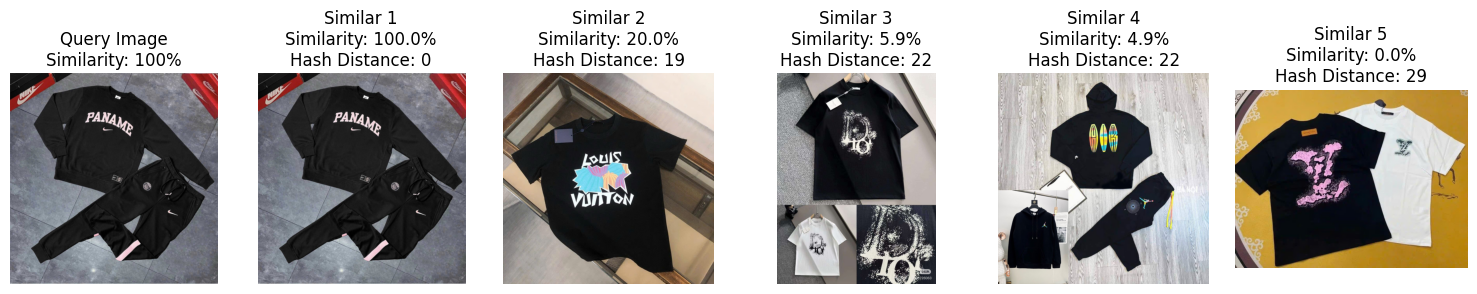

In [14]:
# Thử nghiệm
query_image = "originalImages/462241567_1086240933225233_6752166467388263768_n.png" 
plot_similar_images(query_image)